In [1]:
from __future__ import division
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
%matplotlib inline
plt.style.use('ggplot')

**Description of lag calculation from Siegel et al. 2015 (JCBFM)**

$$C_i(\tau) = (1/n_\tau)\sum \left[ \frac{g(t) \cdot s_i(t + \tau)}{\sigma_{s_i}\sigma_g}  \right]$$

* ***g*** is the gray matter signal
* ***s<sub>i</sub>*** is the signal in voxel ***i***
* ***σ<sub>s<sub>i</sub></sub>*** and  ***σ<sub>g</sub>*** are the standard deviations of the two signals

The summation runs over frames indexed by ***t***, and ***n<sub>τ</sub>***  is the number of frames included after a shift of ***τ***.

To determine the shift that maximizes the cross-correlation function at a temporal resolution finer than 1 TR, the lag (***τ***) corresponding to the maximum of ***C<sub>i</sub> (τ)*** is identified. ***C<sub>i</sub> (τ)*** at this lag, as well as one step forward and backward, is fit with a parabolic function and the peak value, ***C<sub>i</sub>  (τ<sup>m</sup>)*** and corresponding temporal shift ***(τ<sup>m</sup>)*** is computed. Positive and negative values of  ***τ<sup>m</sup>*** correspond, respectively, to a lag or lead relative to the mean gray matter signal.

In [2]:
def get_numerator(signal_a, signal_b, lag):
    """
    Calculates the numerator of the cross-correlation equation.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
    lag : int
        Lag by which signal_b will be shifted relative to signal_a.
        
    Returns
    -------
    array_like (1D)
        Element-wise product of matching time points in the lagged signals.
    """ 
    if lag == 0:
        numerator = np.multiply(signal_a, signal_b)
    # If lag is positive, shift signal_b forwards relative to signal_a.
    if lag > 0:
        numerator = np.multiply(signal_a[lag:], signal_b[0:-lag])
    # If lag is negative, shift signal_b backward relative to signal_a.
    if lag < 0:
        numerator = np.multiply(signal_b[-lag:], signal_a[0:lag])
    return numerator

In [3]:
def get_denominator(signal_a, signal_b):
    """
    Calculates the denominator of the cross-correlation equation.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
        
    Returns
    -------
    float
        Product of the standard deviations of the input signals.
    """ 
    return np.std(signal_a) * np.std(signal_b)

In [4]:
def calc_xcorr(signal_a, signal_b, lag):
    """
    Calculate the cross-correlation of two signals at a given lag.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
    lag : int
        Lag by which signal_b will be shifted relative to signal_a.
        
    Returns
    -------
    float
        Normalized cross-correlation.
    """ 
    xcorr = np.true_divide(1., len(signal_a)-np.absolute(lag)) * np.sum(np.true_divide(get_numerator(signal_a, signal_b, lag),
              get_denominator(signal_a, signal_b)))
    return xcorr

In [5]:
def sliding_xcorr(signal_a, signal_b, lags):
    """
    Calculate the cross-correlation of two signals over a range of lags.
    
    Parameters
    ----------
    signal_a : array_like (1D)
        Reference signal.
    signal_b : array_like (1D)
        Test signal. Must be the same length as signal_a.
    lags : array_like (1D)
        Lags by which signal_b will be shifted relative to signal_a.
        
    Returns
    -------
    array_like (1D)
        Normalized cross-correlation at each lag.
    """ 
    xcorr_vals = []
    for lag in lags:
        xcorr = calc_xcorr(signal_a, signal_b, lag)
        xcorr_vals.append(xcorr)
    return np.array(xcorr_vals)

In [6]:
# Taken from https://gist.github.com/endolith/255291
def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
   
    f is a vector and x is an index for that vector.
   
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
   
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
   
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
   
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
   
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

In [7]:
def report_xcorr(xcorr_array, lags, interp=False):
    """
    Report the maximum value from a cross-correlation array.
    
    """
    lag_shift = np.sum(np.array(lags) > 0)
    if interp == True:
        max_xcorr = parabolic(xcorr_array, np.argmax(xcorr_array))[0] - lag_shift
    else:
        max_xcorr = np.argmax(xcorr_array) - lag_shift
    print("Maximum cross-correlation exists at a lag of {}.".format(max_xcorr))

### Test on dummy data

Two identical aperiodic time-series, with a lag difference of 3 frames.

In [8]:
simple_a = [0, 0, 0, 0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0]
simple_b = [0, 0, 2, 2, 1, 2, 3, 2, 0, -1, -2, -2, 0, 0, 0, 0, 0, 0, 0]
simple_lags = range(-4, 5)

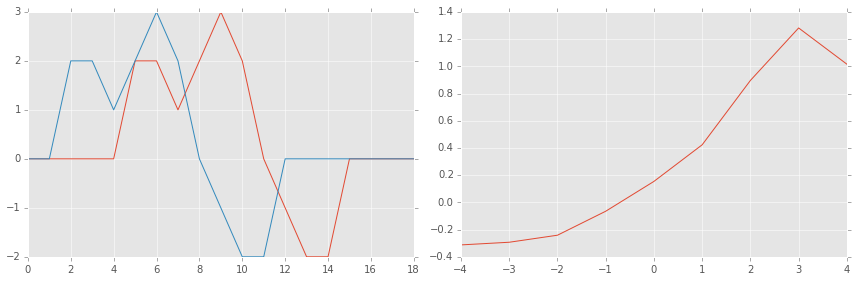

In [9]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(simple_a)
axes[0].plot(simple_b)
axes[1].plot(simple_lags, sliding_xcorr(simple_a, simple_b, simple_lags))
plt.tight_layout()

### Test on more realistic simulated data.

Time series from a random ARMA model, shifted by 7 frames.

In [10]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 143)
z = sm.tsa.arma_generate_sample(ar, ma, 143)
arma_a = np.append(z[-7:], y)
arma_b = np.append(y, z[0:7])

Maximum cross-correlation exists at a lag of 7.


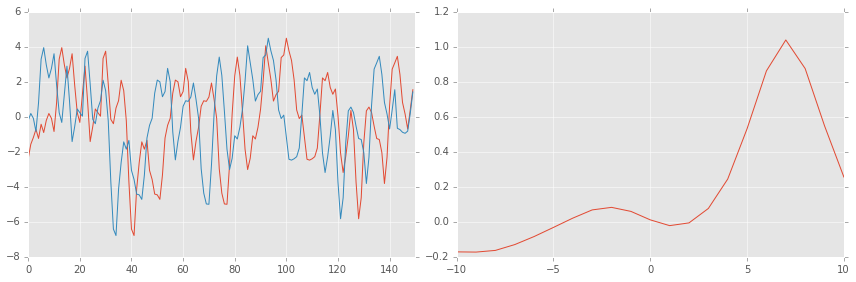

In [11]:
arma_lags = range(-10, 11)
arma_xcorr =  sliding_xcorr(arma_a, arma_b, arma_lags)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(arma_a)
axes[0].set_xlim(0,len(arma_a))
axes[0].plot(arma_b)
axes[1].plot(arma_lags, arma_xcorr)
plt.tight_layout()
report_xcorr(arma_xcorr, arma_lags)

### Test with aliased sampling and parabolic interpolation.

Using the same data as above, but with an aliased sampling window with a width of 2 frames.

In [12]:
arma_a_aliased = np.mean(np.reshape(arma_a, (-1, 3)), axis=1)
arma_b_aliased = np.mean(np.reshape(arma_b, (-1, 3)), axis=1)

Maximum cross-correlation exists at a lag of 7.01939166585.


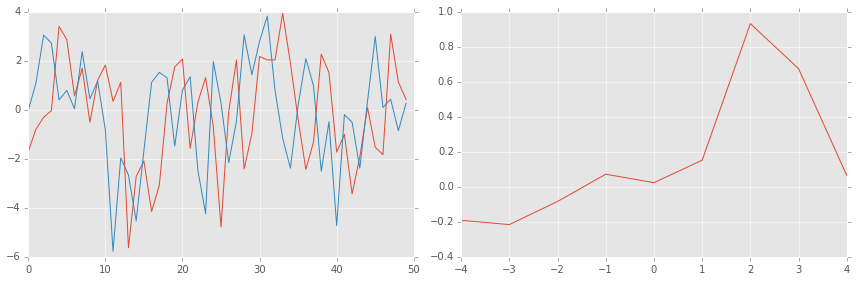

In [13]:
arma_lags_aliased = range(-4, 5)
arma_aliased_xcorr =  sliding_xcorr(arma_a_aliased, arma_b_aliased, arma_lags_aliased)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(arma_a_aliased)
axes[0].set_xlim(0,len(arma_a_aliased))
axes[0].plot(arma_b_aliased)
axes[1].plot(arma_lags_aliased, arma_aliased_xcorr)
plt.tight_layout()
report_xcorr(arma_xcorr, arma_lags, interp=True)

## Test on Real Data

In [88]:
epi = '/home/despoB/mb3152/data/nki_data/preprocessed/pipeline_pipeline/0197584_session_1/functional_mni/_scan_RfMRI_std_2500_rest/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf0/_bandpass_freqs_0.009.0.08/bandpassed_demeaned_filtered_antswarp.nii.gz'
brain_mask = '/home/despoB/mb3152/data/nki_data/preprocessed/pipeline_pipeline/0197584_session_1/functional_brain_mask_to_standard/_scan_RfMRI_std_2500_rest/rest_calc_tshift_resample_volreg_brain_mask_ero_antswarp.nii.gz'
gm_mask = '/home/despo/dlurie/Software/fsl/data/standard/tissuepriors/2mm/avg152T1_gray_bin.nii.gz'

In [91]:
epi_img = nib.load(epi).get_data()

IOError: [Errno 2] No such file or directory: '/home/despoB/mb3152/data/nki_data/preprocessed/pipeline_pipeline/0197584_session_1/functional_mni/_scan_RfMRI_std_2500_rest/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf0/_bandpass_freqs_0.009.0.08/bandpassed_demeaned_filtered_antswarp.nii.gz'

In [9]:
brain_mask_img = nib.load(brain_mask).get_data()
brain_mask_img = brain_mask_img.astype(bool)

In [10]:
gm_mask_img = nib.load(gm_mask).get_data()
gm_mask_img = gm_mask_img.astype(bool)

In [47]:
epi_gm_masked = epi_img[gm_mask_img]
epi_brain_masked = epi_img[brain_mask_img]

In [65]:
lags_pm5 = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
lags_pm4 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

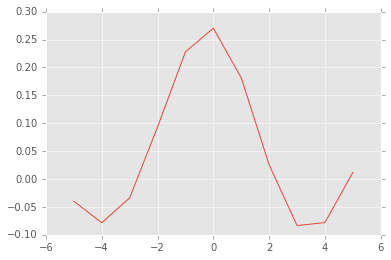

In [77]:
frame_slider = IntSlider(min=0, max=200, step1=1, value=0)
# decorate the plot function with an environment from the UIs:
@interact(frame_select=frame_slider)
def xcorr_viewer(frame_select):
    test_xcorr = xcorr(epi_brain_masked[frame_select], np.mean(epi_gm_masked, axis=0), lags_pm5)
    plt.plot(lags_pm5, test_xcorr)

In [74]:
test_xcorr = xcorr(epi_brain_masked[20], np.mean(epi_gm_masked, axis=0), lags_pm5)

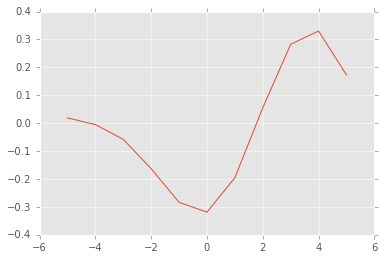

In [75]:
plt.plot(lags_pm5, test_xcorr)

In [21]:
from scipy import signal

In [27]:
np.argmax(test_xcorr)

0

In [28]:
signal.argrelmax(np.array(test_xcorr), order=1)

(array([4]),)

In [23]:
parabolic(test_xcorr, 5)[0] - 4

0.9421620933549022

In [100]:
range(-8, 9)

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [231]:
long_lags = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [153]:
def gen_lag_map(epi_img, brain_mask_img, gm_mask_img, lags):
    epi_gm_masked = epi_img[gm_mask_img]
    signal_a = np.mean(epi_gm_masked, axis=0)
    epi_brain_masked = epi_img[brain_mask_img]
    lag_index_correction = np.sum(np.array(lags) > 0)
    xcorr_array = []
    for voxel in epi_brain_masked:
    #for i, voxel in enumerate(epi_brain_masked):
        #print(i)
        signal_b = voxel
        vox_xcorr = xcorr(signal_a, signal_b, lags)
        xcorr_maxima = signal.argrelmax(np.array(vox_xcorr), order=1)[0]
        if len(xcorr_maxima) == 0:
            interp_max = np.argmax(vox_xcorr)
        elif len(xcorr_maxima) == 1:
            interp_max = parabolic(vox_xcorr, xcorr_maxima[0])[0]
            interp_max = interp_max - lag_index_correction
        elif len(xcorr_maxima) > 1:
            xpeak = xcorr_maxima[np.argmax(vox_xcorr[xcorr_maxima])]
            interp_max = parabolic(vox_xcorr, xpeak)[0]
            interp_max = interp_max - lag_index_correction
        xcorr_array.append(interp_max)
    return(np.array(xcorr_array))

In [155]:
test_out = gen_lag_map(epi_img, brain_mask_img, gm_mask_img, lags_pm5)

In [156]:
unmasked_data = np.zeros(brain_mask_img.shape, dtype=test_out.dtype)
unmasked_data[brain_mask_img] = test_out

In [157]:
a = np.ma.masked_where(unmasked_data == 0, unmasked_data)

In [158]:
from ipywidgets import interact, IntSlider

In [171]:
cwb = plt.cm.coolwarm
cwb.set_bad(color='black')

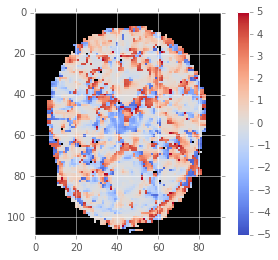

In [175]:
slice_slider = IntSlider(min=0, max=91, step1=1, value=45)
# decorate the plot function with an environment from the UIs:
@interact(slice_select=slice_slider)
def slice_viewer(slice_select):
    plt.imshow(a.T[slice_select,:,:], cmap=cwb, vmin=-5, vmax=5, interpolation='none')
    plt.colorbar()